In [3]:
import pandas as pd
import numpy as np
import networkx as nx

from tqdm import tqdm
import collections

import seaborn as sns
import sklearn
from matplotlib import pyplot as plt

In [4]:
nx.__version__

'2.4'

In [5]:
SEED = 224
DISPLAY = True
EXPORT = False
RECOMPUTE = False

# Import (with minimal preprocessing)

In [6]:
if (RECOMPUTE):
    orig_dat_1 = pd.read_excel("data/online_retail_II.xlsx",
                               sheet_name="Year 2009-2010", index_col=None,
                               keep_default_na=True, parse_dates=['InvoiceDate'])
    orig_dat_2 = pd.read_excel("data/online_retail_II.xlsx",
                               sheet_name="Year 2010-2011", index_col=None,
                               keep_default_na=True, parse_dates=['InvoiceDate'])
    print(len(orig_dat_1) + len(orig_dat_2), len(orig_dat))
    
    orig_dat = (pd.concat([orig_dat_1, orig_dat_2])
                  .reset_index()
                  .drop('index', axis=1)
                  .rename(columns={"Customer ID":"CustomerID"})
               )
    
    if (EXPORT):
        orig_dat.to_csv("online_retail_II.csv", index=False)
        
else:
    orig_dat = pd.read_csv("data/online_retail_II.csv", parse_dates=['InvoiceDate'])

assert len(orig_dat) == 1067371

In [7]:
# Remember to unzip data in data
dat = orig_dat.copy()
dat.head()

Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  CustomerID         Country  
0 2009-12-01 07:45:00   6.95     13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75     13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75     13085.0  United Kingdom  
3 2009-12-01 07:45:00   2.10     13085.0  United Kingdom  
4 2009-12-01 07:45:00   1.25     13085.0  United Kingdom

In [8]:
dat.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'CustomerID', 'Country'],
      dtype='object')

In [9]:
# Note that Description is ONLY NULL when customer is null
orig_dat[pd.isnull(orig_dat.Description)].CustomerID.unique()

array([nan])

In [10]:
dat[dat['CustomerID'] == 17850.0] # one customer bought 2827 things! (apparently most were returns though)

Invoice StockCode                         Description  Quantity  \
12150    490373    85014B     RED/WHITE DOTS RUFFLED UMBRELLA         6   
12151    490373   15056BL             EDWARDIAN PARASOL BLACK         6   
12152    490373    79323P                  PINK CHERRY LIGHTS         4   
12153    490373    79323W                 WHITE CHERRY LIGHTS         4   
12154    490373     22352    LUNCHBOX WITH CUTLERY RETROSPOT         12   
...         ...       ...                                 ...       ...   
612359  C543611     82483  WOOD 2 DRAWER CABINET WHITE FINISH        -1   
612360  C543611     21874                   GIN AND TONIC MUG        -1   
612361  C543611     71477   COLOUR GLASS. STAR T-LIGHT HOLDER        -2   
612362  C543611     82483  WOOD 2 DRAWER CABINET WHITE FINISH        -1   
612363  C543611     21169     YOU'RE CONFUSING ME METAL SIGN         -2   

               InvoiceDate  Price  CustomerID         Country  
12150  2009-12-05 12:28:00   4.95     17850.0  United Kingdom  
12151  2009-12-05 12:28:00   4.95     17850.0  United Kingdom  
12152  2009-12-05 12:28:00   5.45     17850.0  United Kingdom  
12153  2009-12-05 12:28:00   5.45     17850.0  United Kingdom  
12154  2009-12-05 12:28:00   2.10     17850.0  United Kingdom  
...                    ...    ...         ...             ...  
612359 2011-02-10 14:38:00   4.95     17850.0  United Kingdom  
612360 2011-02-10 14:38:00   1.06     17850.0  United Kingdom  
612361 2011-02-10 14:38:00   2.75     17850.0  United Kingdom  
612362 2011-02-10 14:38:00   4.95     17850.0  United Kingdom  
612363 2011-02-10 14:38:00   1.45     17850.0  United Kingdom  

[2827 rows x 8 columns]

In [11]:
# don't care about transactions with no item or no customer
dat = dat.dropna(subset=['StockCode', 'CustomerID'], how='any', axis=0) 
dat.head()

Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  CustomerID         Country  
0 2009-12-01 07:45:00   6.95     13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75     13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75     13085.0  United Kingdom  
3 2009-12-01 07:45:00   2.10     13085.0  United Kingdom  
4 2009-12-01 07:45:00   1.25     13085.0  United Kingdom

In [12]:
dat.sort_values('Price') # A lot of the largest/smallest prices come from manual/discount

Invoice StockCode                   Description  Quantity  \
248583   513416     22423      REGENCY CAKESTAND 3 TIER         5   
392008   527084     22630          DOLLY GIRL LUNCH BOX        64   
16107    490727         M                        Manual         1   
612250   543599    84535B  FAIRY CAKES NOTEBOOK A6 SIZE        16   
945865   572893     21208   PASTEL COLOUR HONEYCOMB FAN         5   
...         ...       ...                           ...       ...   
135013   502263         M                        Manual         1   
135012  C502262         M                        Manual        -1   
135014  C502264         M                        Manual        -1   
241824  C512770         M                        Manual        -1   
748142  C556445         M                        Manual        -1   

               InvoiceDate     Price  CustomerID         Country  
248583 2010-06-24 12:34:00      0.00     13089.0  United Kingdom  
392008 2010-10-14 15:33:00      0.00     14646.0     Netherlands  
16107  2009-12-07 16:38:00      0.00     17231.0  United Kingdom  
612250 2011-02-10 13:08:00      0.00     17560.0  United Kingdom  
945865 2011-10-26 14:36:00      0.00     18059.0  United Kingdom  
...                    ...       ...         ...             ...  
135013 2010-03-23 15:22:00  10953.50     12918.0  United Kingdom  
135012 2010-03-23 15:20:00  10953.50     12918.0  United Kingdom  
135014 2010-03-23 15:24:00  10953.50     12918.0  United Kingdom  
241824 2010-06-17 16:52:00  25111.09     17399.0  United Kingdom  
748142 2011-06-10 15:31:00  38970.00     15098.0  United Kingdom  

[824364 rows x 8 columns]

In [13]:
# Get rid of some of these manual codes
dat = dat[~dat.StockCode.isin(['M', 'POST', 'D', 'DOT', 'CRUK', 'C2', 'BANK CHARGES', 'ADJUST', 'ADJUST2', 'TEST001'])]
dat.sort_values('Price')

Invoice StockCode                         Description  Quantity  \
682503   550188     22636  CHILDS BREAKFAST SET CIRCUS PARADE         1   
471776   533822     22845    VINTAGE CREAM CAT FOOD CONTAINER         1   
972255   574920     23480      MINI LIGHTS WOODLAND MUSHROOMS         1   
471775   533822     22846          BREAD BIN DINER STYLE RED          1   
964822   574469     22385           JUMBO BAG SPACEBOY DESIGN        12   
...         ...       ...                                 ...       ...   
317135  C520298     22656        VINTAGE BLUE KITCHEN CABINET        -1   
659468   547814     22656        VINTAGE BLUE KITCHEN CABINET         1   
368234   525022     22655         VINTAGE RED KITCHEN CABINET         1   
748132   556444     22502      PICNIC BASKET WICKER 60 PIECES        60   
748143   556446     22502      PICNIC BASKET WICKER 60 PIECES         1   

               InvoiceDate  Price  CustomerID         Country  
682503 2011-04-14 18:57:00    0.0     12457.0     Switzerland  
471776 2010-11-19 09:40:00    0.0     12647.0         Germany  
972255 2011-11-07 16:34:00    0.0     13985.0  United Kingdom  
471775 2010-11-19 09:40:00    0.0     12647.0         Germany  
964822 2011-11-04 11:55:00    0.0     12431.0       Australia  
...                    ...    ...         ...             ...  
317135 2010-08-25 11:35:00  295.0     16985.0  United Kingdom  
659468 2011-03-25 14:19:00  295.0     13452.0  United Kingdom  
368234 2010-10-03 12:00:00  295.0     17412.0  United Kingdom  
748132 2011-06-10 15:28:00  649.5     15098.0  United Kingdom  
748143 2011-06-10 15:33:00  649.5     15098.0  United Kingdom  

[820648 rows x 8 columns]

In [14]:
# Remove cancellations
dat = dat[~dat.Invoice.str.startswith('C')]

In [15]:
# end preprocessing

In [16]:
len(orig_dat), len(dat)

(1067371, 802714)

# Build graphs with node and edge features

In [17]:
bins = pd.date_range(start=dat.InvoiceDate.min(), end=dat.InvoiceDate.max(), freq='W-TUE')
bins, len(bins), dat.InvoiceDate.min(), dat.InvoiceDate.max()

(DatetimeIndex(['2009-12-01 07:45:00', '2009-12-08 07:45:00',
                '2009-12-15 07:45:00', '2009-12-22 07:45:00',
                '2009-12-29 07:45:00', '2010-01-05 07:45:00',
                '2010-01-12 07:45:00', '2010-01-19 07:45:00',
                '2010-01-26 07:45:00', '2010-02-02 07:45:00',
                ...
                '2011-10-04 07:45:00', '2011-10-11 07:45:00',
                '2011-10-18 07:45:00', '2011-10-25 07:45:00',
                '2011-11-01 07:45:00', '2011-11-08 07:45:00',
                '2011-11-15 07:45:00', '2011-11-22 07:45:00',
                '2011-11-29 07:45:00', '2011-12-06 07:45:00'],
               dtype='datetime64[ns]', length=106, freq='W-TUE'),
 106,
 Timestamp('2009-12-01 07:45:00'),
 Timestamp('2011-12-09 12:50:00'))

In [18]:
import networkx as nx
import os

class TemporalGraph:
    
    def __init__(self, node_ordering, index):
        self.frames = {}
        self.index = index # save this as an accessor to which bins exist
        self.node_ordering = node_ordering
    
    def add_frame(self, ind, frame):
        self.frames[ind] = frame
        
    def get_frame(self, ind):
        """ Returns a copy of the frame at the index.
        """
        return self.frames[ind].copy()
        
    def read_gpickles(self, directory):
        for ind_path in os.listdir(directory):
            ind = os.path.basename(ind_path).split(".")[0]
            self.frames[ind] = nx.read_gpickle(os.path.join(directory, ind_path))
            
    def write_gpickles(self, directory):
        if not os.path.isdir(directory):
            os.mkdir(directory)
            
        for ind, frame in self.frames.items():
            nx.write_gpickle(frame, os.path.join(directory, "%s.pkl" % ind))

## Some descriptions are misspelled/updated later.
We'll keep the last occurrence.

In [19]:
duplicated = dat[['StockCode', 'Description']].drop_duplicates().sort_values('StockCode')
duplicated[duplicated.duplicated(subset=['StockCode'], keep=False)]

StockCode                          Description
67142      15058A      BLUE WHITE SPOTS GARDEN PARASOL
548898     15058A         BLUE POLKADOT GARDEN PARASOL
67188      15058B      PINK WHITE SPOTS GARDEN PARASOL
461044     15058B         PINK POLKADOT GARDEN PARASOL
119710      16011                      ANIMAL STICKERS
...           ...                                  ...
912110     90014B           GOLD M.O.P. ORBIT NECKLACE
1030162    90014C      SILVER AND BLACK ORBIT NECKLACE
6363       90014C          SILVER/BLACK ORBIT NECKLACE
735062      90208    PAIR OF PINK FLOWER CLUSTER SLIDE
74044       90208  PAIR OF ENAMEL FLOWER CLUSTER SLIDE

[1304 rows x 2 columns]

In [20]:
def create_frame(dat):
    G = nx.Graph()
    
    #Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
    #   'Price', 'CustomerID', 'Country'],
    #  dtype='object')
        
    custData = dat[['CustomerID', 'Country']].drop_duplicates(subset=['CustomerID'], keep='last')
    stockData = dat[['StockCode', 'Description']].drop_duplicates(subset=['StockCode'], keep='last')
    
    assert len(custData) == len(custData.CustomerID.unique())
    assert len(stockData) == len(stockData.StockCode.unique())
    
    for i, stock in stockData.iterrows():
        G.add_node(stock.StockCode,
                   description=stock.Description)
    
    for i, customer in custData.iterrows():
        G.add_node(customer.CustomerID,
                   country=customer.Country)
        
    for i, row in dat.iterrows():
        G.add_edge(row.StockCode,
                   row.CustomerID,
                   key=row.Invoice,
                   quantity=row.Quantity,
                   date=row.InvoiceDate,
                   price=row.Price) # sometimes price changes, sale?
        
    return G

In [21]:
TG = TemporalGraph(None, None) #node_ordering, bins)

path = "data/temporal_bipartite_snapshot_no_node_ordering"

if (not os.path.isdir("data/temporal_bipartite_snapshot_no_node_ordering") or RECOMPUTE):
    bin_dat = dat[dat.InvoiceDate < bins[0]]
    frame = create_frame(bin_dat)
    TG.add_frame(dat.InvoiceDate.min(), frame)

    for i in range(len(bins)):
        start = bins[i]
        if i+1 == len(bins):
            end = dat.InvoiceDate.max()
        else:
            end = bins[i+1] + 1

        bin_dat = dat[(dat.InvoiceDate >= start) & (dat.InvoiceDate < end)]
        frame = create_frame(bin_dat)
        TG.add_frame(start, frame)
        print(start, end, len(bin_dat))
        
else:
    TG.read_gpickles("data/temporal_bipartite_snapshot_no_node_ordering")

/home/clare/anaconda3/envs/cs224w/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  from ipykernel import kernelapp as app


2009-12-01 07:45:00 2009-12-15 07:45:00 22941
2009-12-08 07:45:00 2009-12-22 07:45:00 17242
2009-12-15 07:45:00 2009-12-29 07:45:00 7756
2009-12-22 07:45:00 2010-01-05 07:45:00 1215
2009-12-29 07:45:00 2010-01-12 07:45:00 4681
2010-01-05 07:45:00 2010-01-19 07:45:00 9286
2010-01-12 07:45:00 2010-01-26 07:45:00 11612
2010-01-19 07:45:00 2010-02-02 07:45:00 12760
2010-01-26 07:45:00 2010-02-09 07:45:00 12212
2010-02-02 07:45:00 2010-02-16 07:45:00 10667
2010-02-09 07:45:00 2010-02-23 07:45:00 11223
2010-02-16 07:45:00 2010-03-02 07:45:00 12675
2010-02-23 07:45:00 2010-03-09 07:45:00 14186
2010-03-02 07:45:00 2010-03-16 07:45:00 13292
2010-03-09 07:45:00 2010-03-23 07:45:00 12430
2010-03-16 07:45:00 2010-03-30 07:45:00 15156
2010-03-23 07:45:00 2010-04-06 07:45:00 12244
2010-03-30 07:45:00 2010-04-13 07:45:00 10354
2010-04-06 07:45:00 2010-04-20 07:45:00 13009
2010-04-13 07:45:00 2010-04-27 07:45:00 13982
2010-04-20 07:45:00 2010-05-04 07:45:00 13512
2010-04-27 07:45:00 2010-05-11 07:45:0

In [22]:
print(len(TG.frames))

106


In [23]:
if (EXPORT):
    TG.write_gpickles("data/temporal_bipartite_snapshot_no_node_ordering")

# Params

In [24]:
# bipartite
node_id = ['StockCode', 'CustomerID', ]
edge_features = ['Invoice', 'Quantity', 'InvoiceDate',]
nodes_features = ['Description', 'Price', 'Country']

# stockcodes only
#node_id = ['StockCode',]
#edge_features = ['Invoice', 'Quantity', 'InvoiceDate', 'CustomerID',  'Country']
#nodes_features = ['Description', 'Price', ]

# customers only
#node_id = ['CustomerID', ]
#edge_features = ['StockCode', 'Description', 'Price', 'Invoice', 'Quantity', 'InvoiceDate',]
#nodes_features = ['Country']

In [25]:
# boolean settings
params = [
    #("directed", "undirected"), # does direction matter?
    #("stock_and_customer", "stock_only", "customer_only"), # bipartite or contracted bipartite
    #("multi", "simple"), # use quantity as weights/multiedges?
    ("snapshot", "cumulative") # snapshot = only purchases made in time window, cumulative = sum up
]

In [26]:
canonical_users = dat.CustomerID.unique()
canonical_items = dat.StockCode.unique()

In [27]:
G = create_frame(dat)

In [28]:
pos = nx.drawing.layout.bipartite_layout(G, canonical_users)

3330


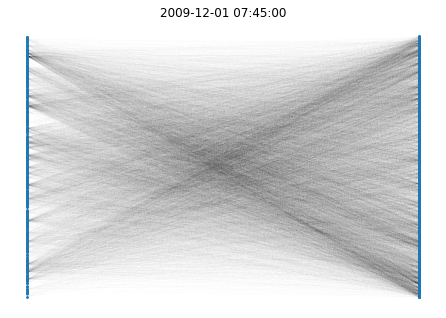

3006


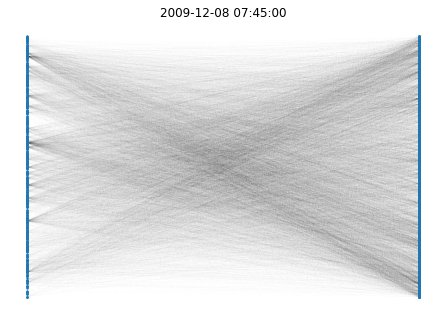

2241


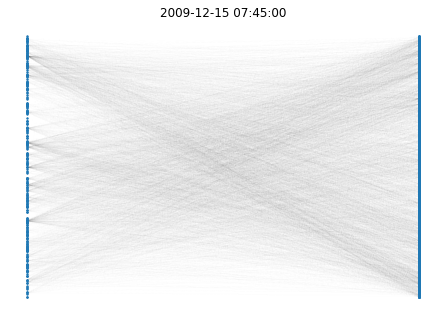

812


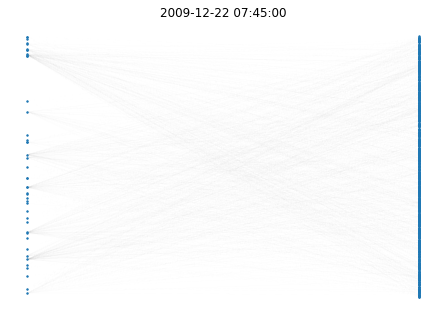

1684


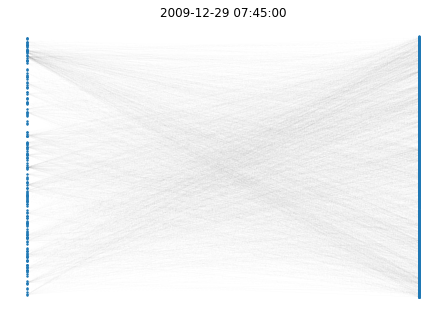

2199


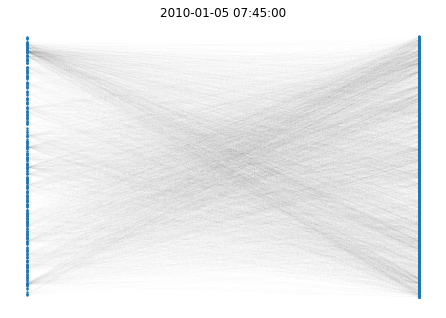

2361


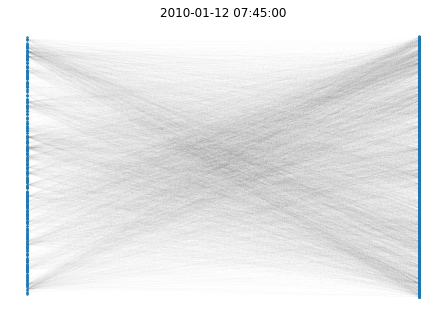

2480


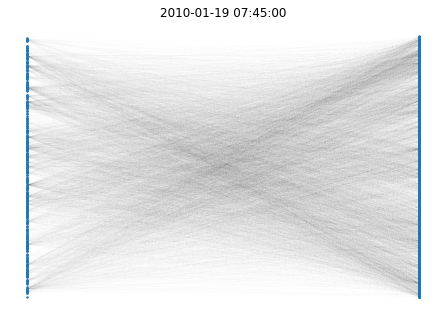

2454


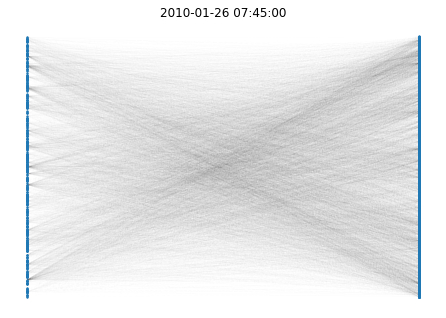

2303


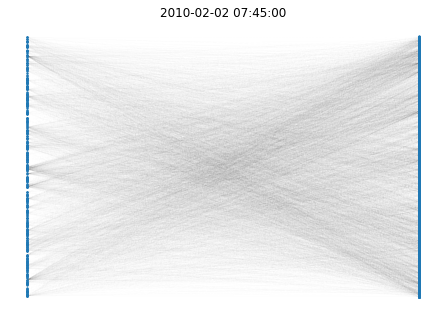

2409


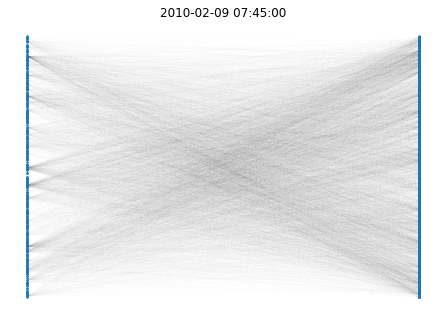

2502


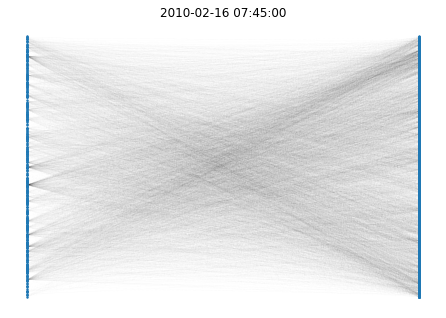

2752


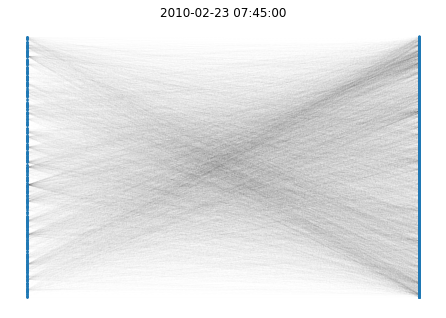

2732


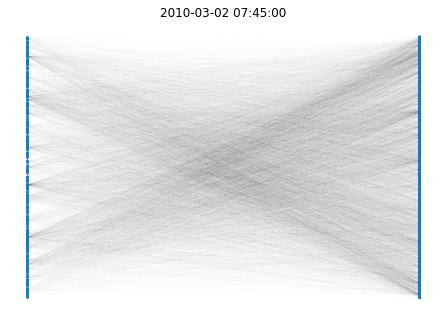

2521


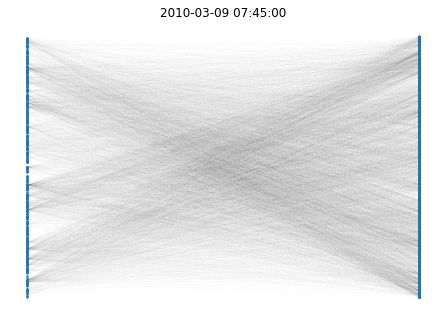

2705


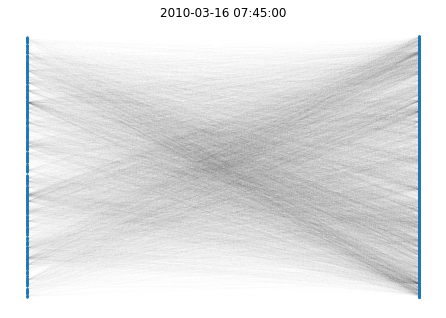

2470


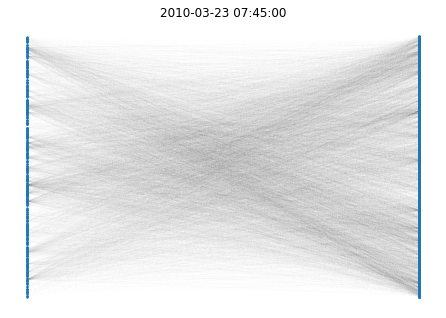

2316


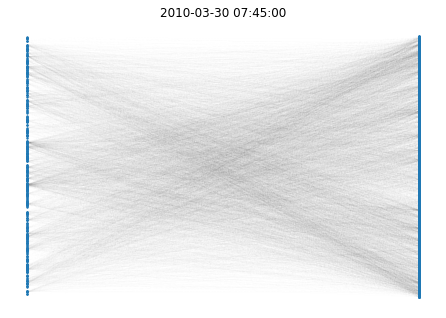

2416


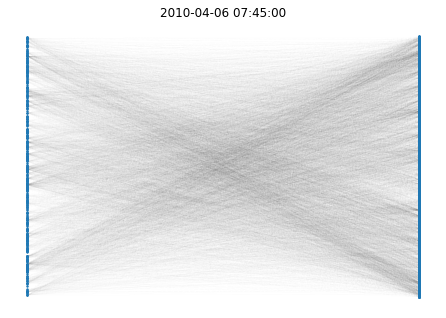

2389


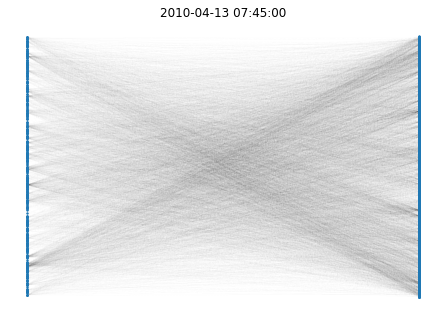

2471


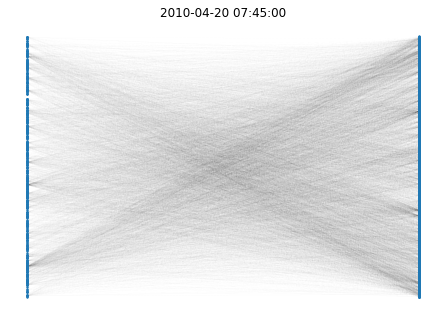

2545


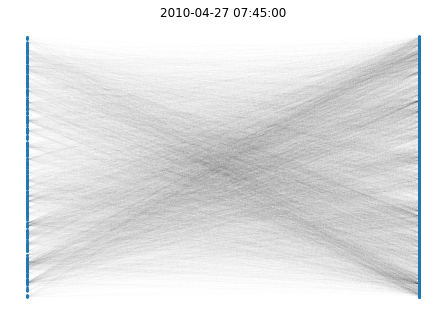

2581


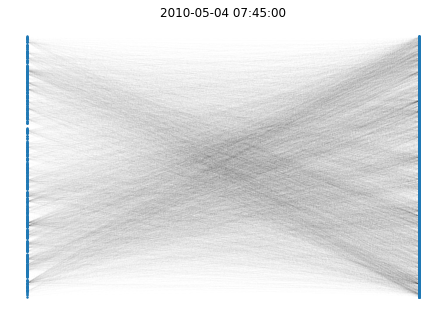

2520


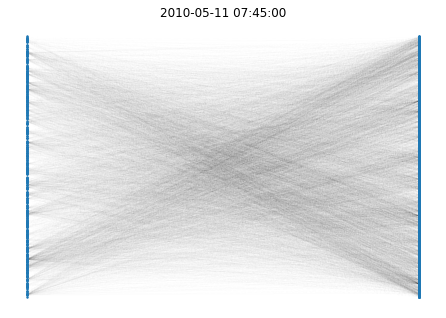

2441


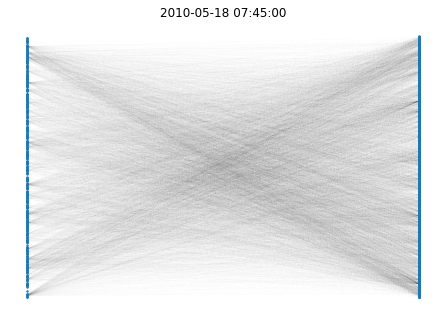

2535


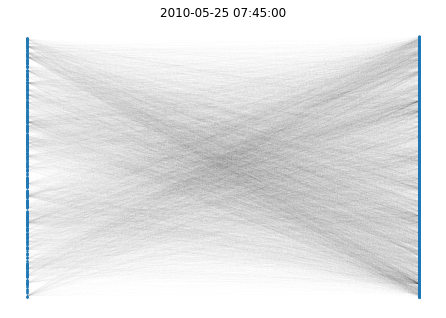

2718


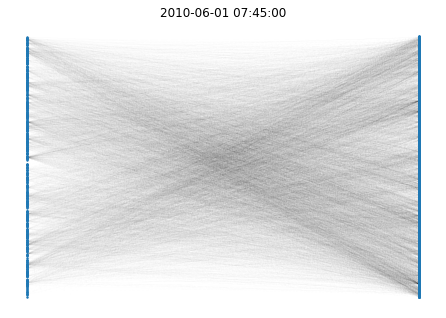

2643


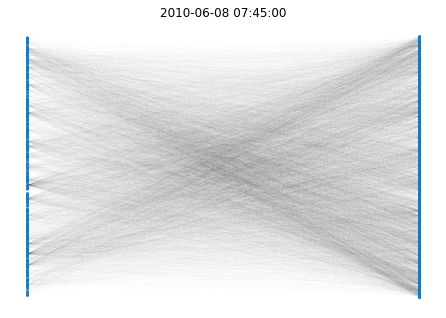

2485


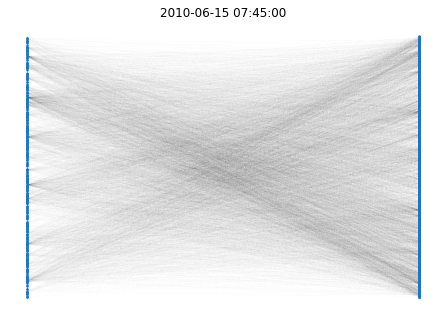

2476


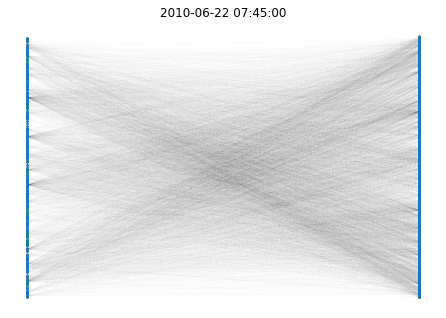

2406


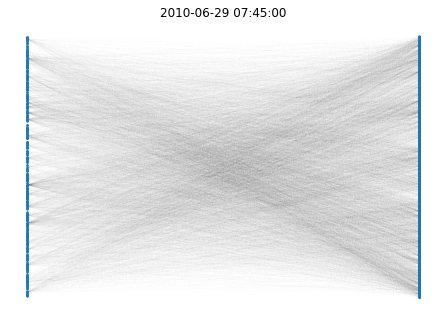

2408


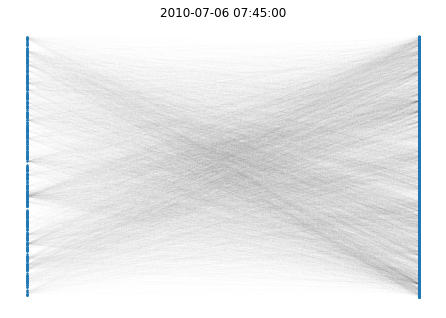

2473


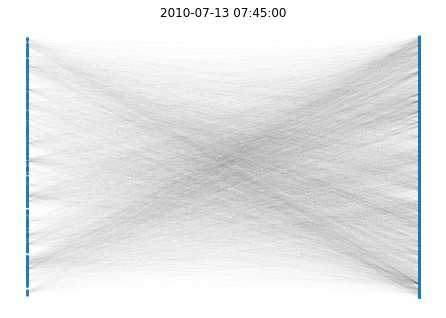

2440


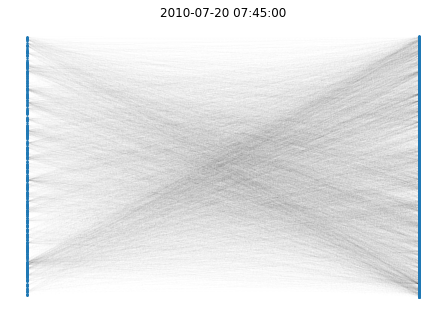

2486


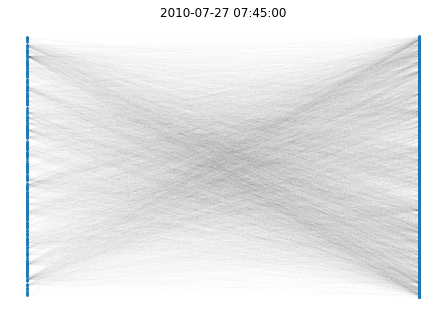

2415


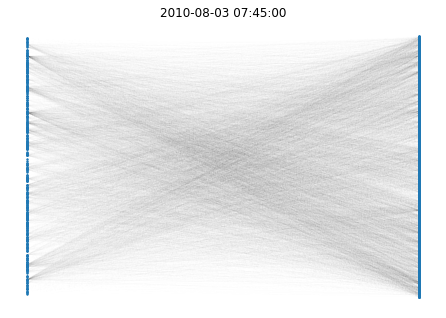

2506


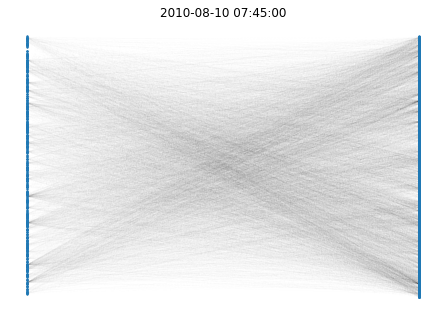

2518


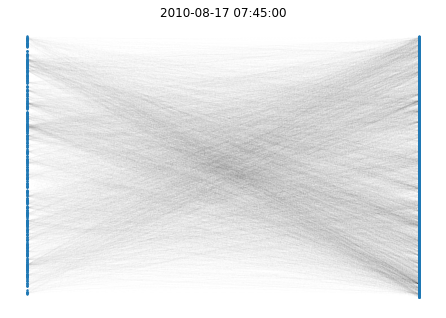

2376


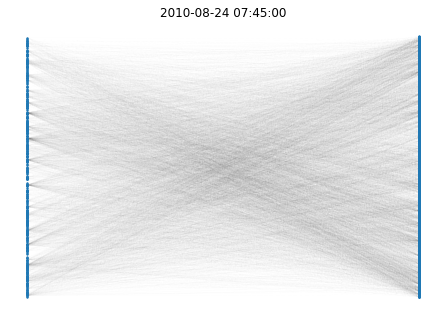

2481


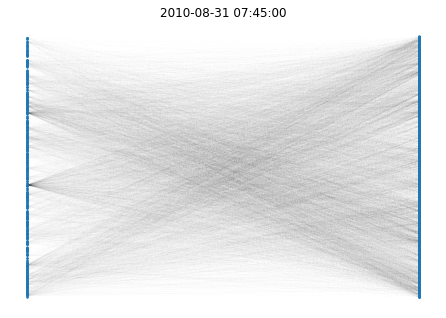

2668


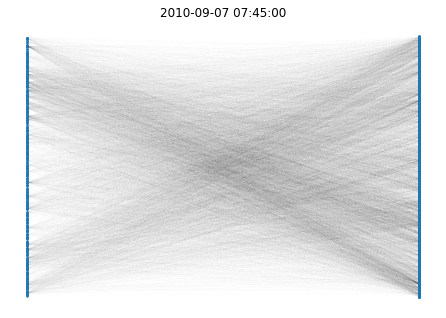

2751


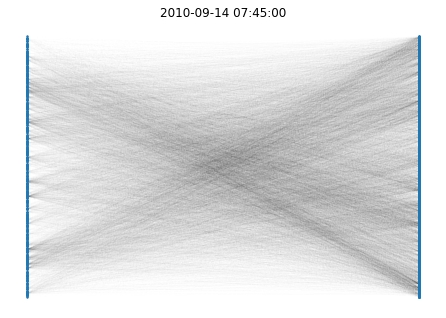

2819


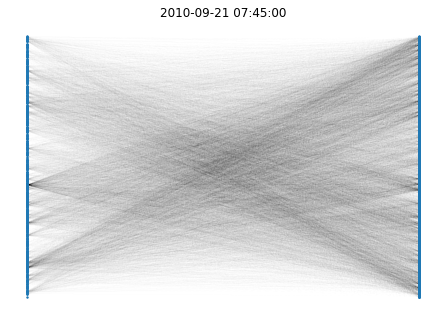

2997


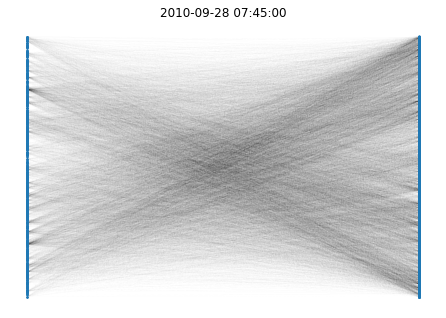

3147


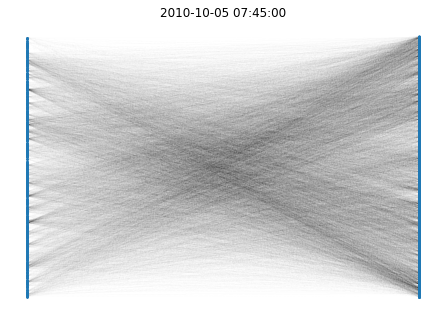

3120


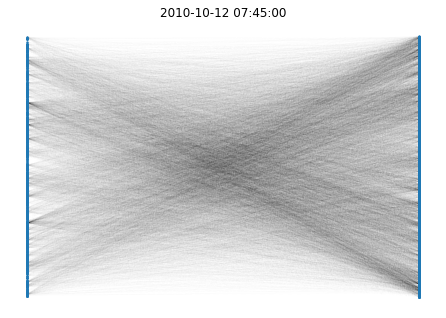

2962


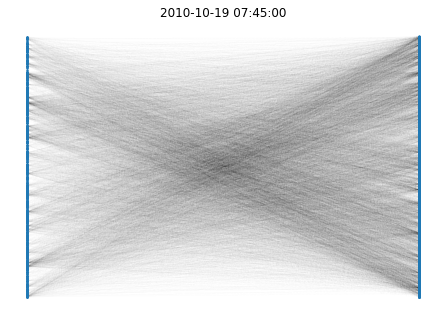

2977


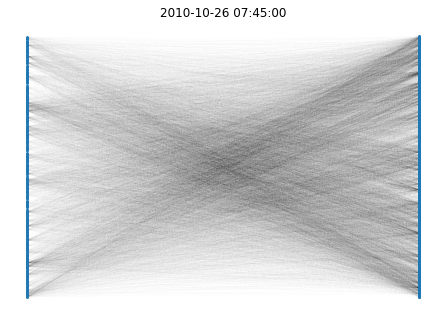

3276


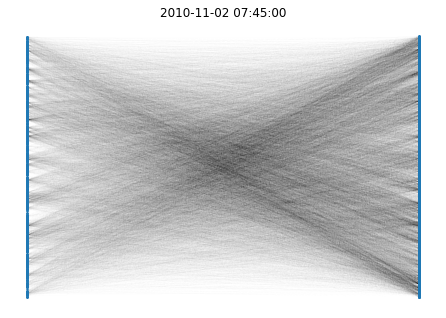

3426


In [ ]:
EXPORT = True

if (DISPLAY):
    for ind, frame in TG.frames.items():
        # Slow - only draw subgraphs
        print(len(frame))
        nx.draw(frame, pos=pos, node_size=2, width=0.001)
        plt.title(str(ind))
        plt.show()
        if (EXPORT):
            plt.savefig(os.path.join("data", "figures", str(ind) + ".png"))

2684


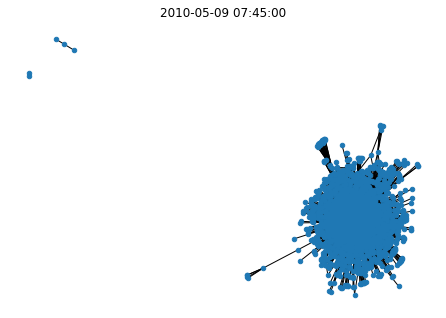

3092


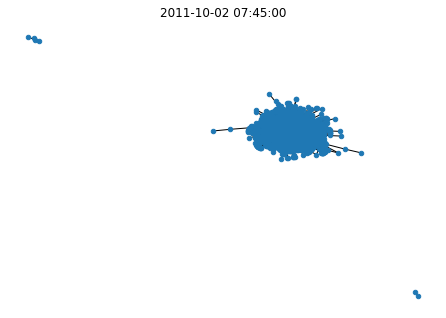

2508


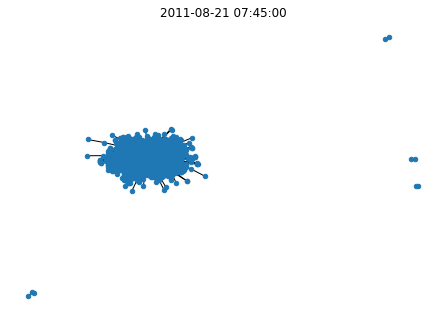

1000


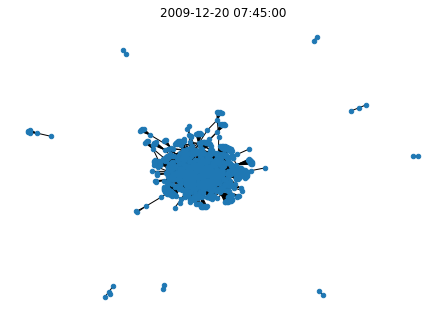

2354


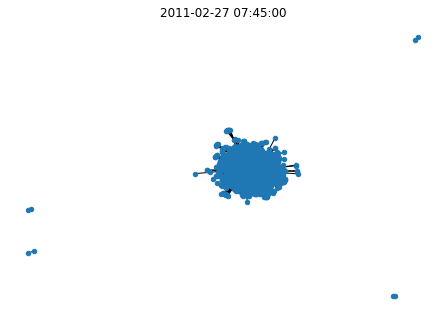

2403


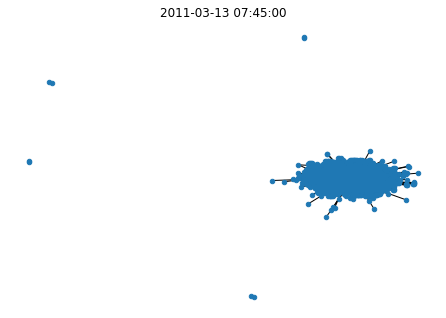

2650


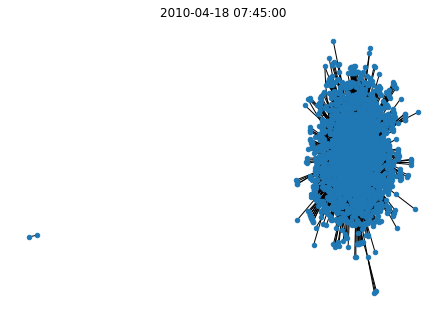

2228


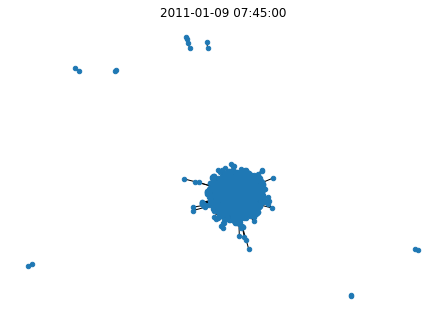

2634


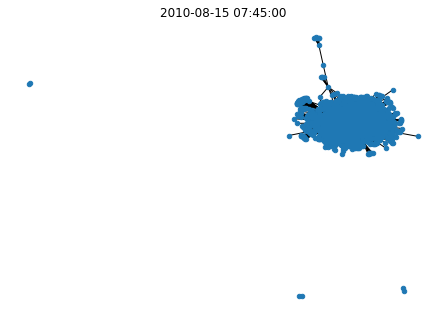

2572


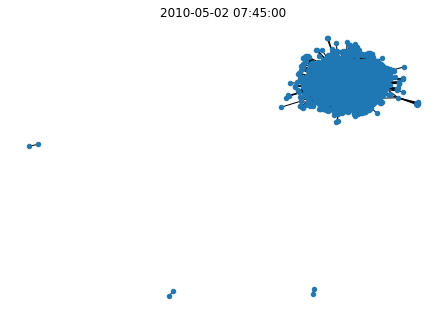

2512


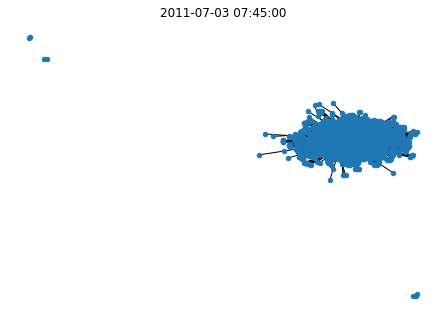

3125


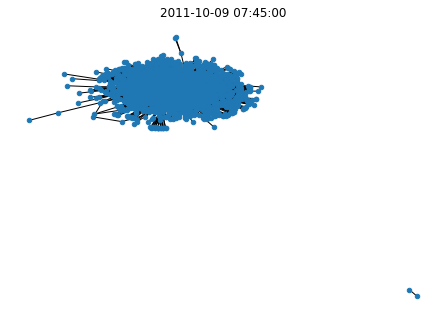

3376


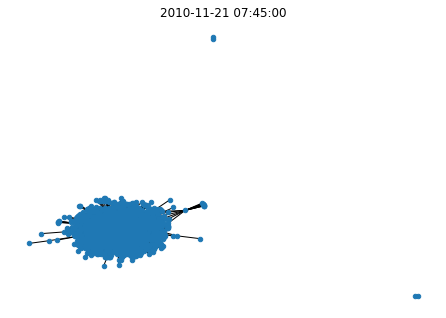

2520


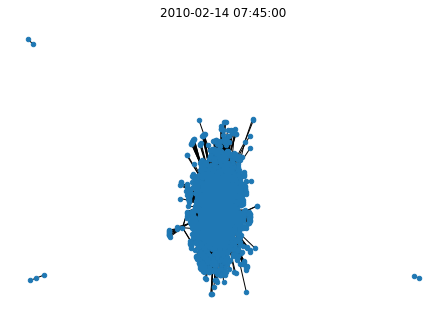

2335


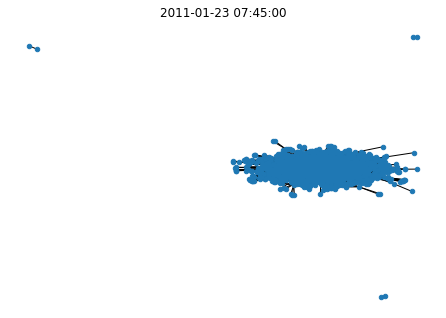

2254


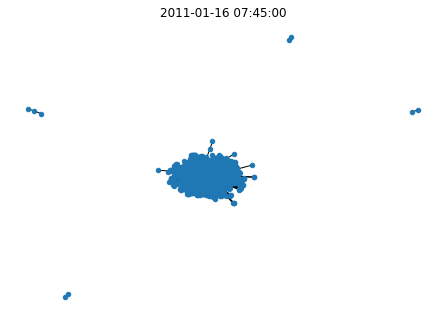

2565


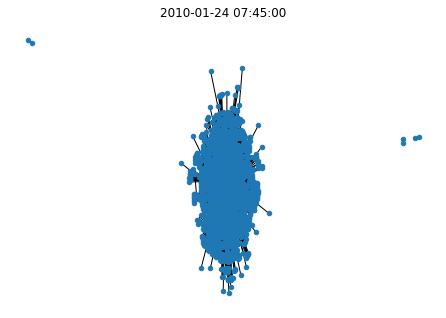

3460


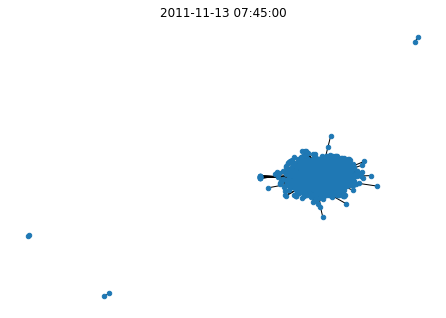

2622


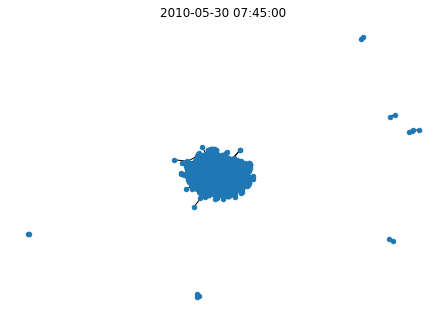

2388


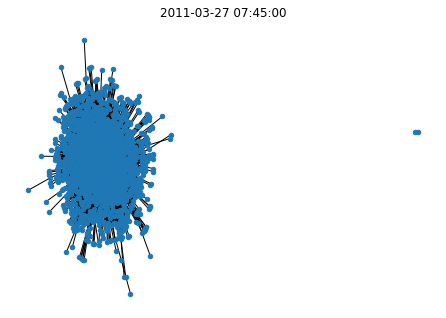

2322


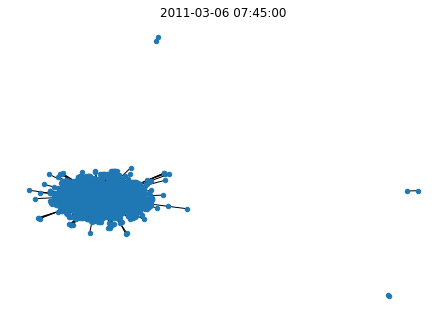

2583


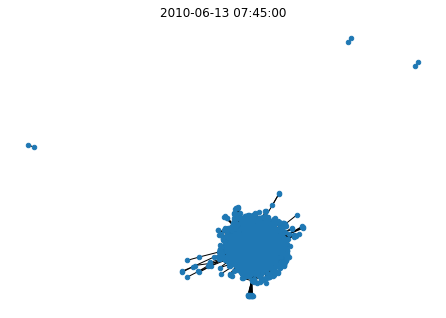

2634


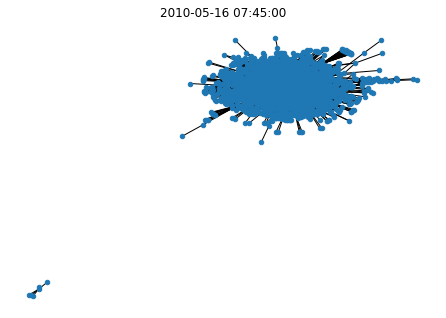

2474


KeyboardInterrupt: 

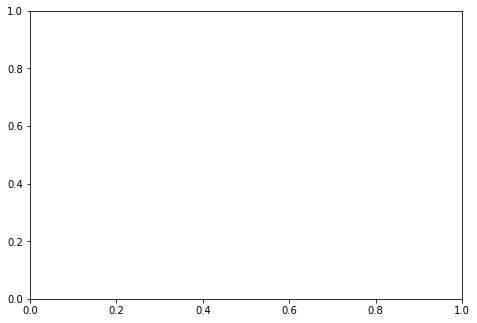

In [24]:
if (DISPLAY):
    for ind, frame in TG.frames.items():
        # Slow - only draw subgraphs
        print(len(frame))
        nx.draw(frame, pos=pos, node_size=2)
        plt.title(str(ind))
        plt.show()